# Overview

This project represents an attempt to utilize machine learning and natural language processing techniques to predict NPS sentiments (Promotor, Passive, Detractor) based on surveys submitted through the NPS system. 

Author: Eric G. Suchanek, PhD for BestBuy.


Methods tried: 
* Sentiment analysis using textblob
* RNN
* LSTM
* BERT
* BoW

The following directory structure must be maintained:  
* main directory/
* notebook/  <-- where this notebook resides
    --data/
    -- raw/
    -- clean/
    -- pass/
    -- prom/
    -- det/

Based on: https://erleem.medium.com/nlp-complete-sentiment-analysis-on-amazon-reviews-374e4fea9976

(c) 2022 BestBuy, all rights reserved. Confidential. Do not share.

# Imports

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import bby

: 

In [2]:
import re
import matplotlib.pyplot as plt
import string
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
import pickle

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

from keras.preprocessing.text import text_to_word_sequence

import datetime

from bby.util import lemma_remove_stopwords
from bby.util import sent_to_words, get_wordnet_pos, detokenize

from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint


# Data importing and exploration

In [3]:
NPS_df = pd.read_csv('../data/clean/NPS_NATL_subset.csv')
#NPS_df = pd.read_csv('../data/clean/NPS_NATL_small.csv')
NPS_df.head(5)

,Location,Workforce,NPS® Breakdown,respid2,NPS_Code,NPSCommentCleaned,NPSCommentLemmatised,NPSCommentPolarity,NPSCommentSubjectivity,OverallCommentCleaned,OverallCommentLemmatised,OverallCommentPolarity,OverallCommentSubjectivity
0,1763,Precinct,Promoter,7053157,2,staff in store in person close by when need them,"Staff in store, in person, close by when I nee...",0.000000,0.000000,was told the issue is more related to gmail th...,Was told the issue is more related to gmail th...,0.250000,0.45
1,832,Precinct,Promoter,6984308,2,adieb anbari was beyond helpful he answered al...,Adieb Anbari was beyond helpful . He answered ...,0.100000,0.600000,adieb was great would recommend him to help an...,Adieb was great I would recommend him to help ...,0.800000,0.75
2,288,Precinct,Promoter,6980586,2,quick and knowledgeable,Quick and knowledgeable,0.333333,0.500000,xyxyxz,xyxyxz,0.000000,0.00
3,168,Precinct,Promoter,6789897,2,he called back quickly within minutes and was ...,He called back quickly (within 5 minutes) and ...,0.414444,0.426667,appreciate his quick and knowledgeable response,Appreciate his quick and knowledgeable response.,0.333333,0.50
4,836,Precinct,Promoter,6896172,2,had really good experience thanks to your tech...,I had a really good experience thanks to your ...,0.450000,0.400000,ricky finished with his prior appt so he took ...,Ricky finished with his prior appt so he took ...,0.050000,0.15


In [4]:
#Let's get the dataset lenght
len(NPS_df)

26703

In [5]:
#How's distributed the dataset? Is it biased?
NPS_df.groupby('NPS® Breakdown').nunique()

,Location,Workforce,respid2,NPS_Code,NPSCommentCleaned,NPSCommentLemmatised,NPSCommentPolarity,NPSCommentSubjectivity,OverallCommentCleaned,OverallCommentLemmatised,OverallCommentPolarity,OverallCommentSubjectivity
NPS® Breakdown,,,,,,,,,,,,
Detractor,928,2,10017,1,9778,9881,2267,2254,6999,7072,1942,1963
Passive,925,2,7785,1,7295,7463,1327,1190,4126,4206,1176,1133
Promoter,929,2,8901,1,7780,8099,995,863,4306,4509,932,863


<BarContainer object of 3 artists>

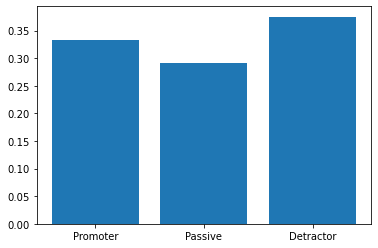

In [6]:
#Checking balance of target classes
sentiments = list(NPS_df["NPS® Breakdown"].unique())

sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

# Data cleaning


In [7]:
# grab the NPS and NPS overall comments for all stores
#overall_list = NPS_df['OverallCommentLemmatised'].apply(lemma_remove_stopwords)


def str_it(_ls):
    ls = str(_ls)
    word_tokens = word_tokenize(ls)
    ls = [w for w in word_tokens]

    ls = " ".join(ls)
    return ls
    

nps_list = NPS_df['NPSCommentCleaned'].apply(str_it)
data_words = list(sent_to_words(nps_list))
len(data_words)

data = []

for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])


['staff in store in person close by when need them', 'adieb anbari was beyond helpful he answered all my questions got me in and out of there as fast as possible and even entertained my year old by answering all her questions and making boat out of paper for her', 'quick and knowledgeable', 'he called back quickly within minutes and was very good at explaining the reason for our issue', 'had really good experience thanks to your tech named ricky']


# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Detractor, Passive and Promoter to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [8]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
NPS_df['code'] = LE.fit_transform(NPS_df['NPS® Breakdown'])
NPS_df.head()

,Location,Workforce,NPS® Breakdown,respid2,NPS_Code,NPSCommentCleaned,NPSCommentLemmatised,NPSCommentPolarity,NPSCommentSubjectivity,OverallCommentCleaned,OverallCommentLemmatised,OverallCommentPolarity,OverallCommentSubjectivity,code
0,1763,Precinct,Promoter,7053157,2,staff in store in person close by when need them,"Staff in store, in person, close by when I nee...",0.000000,0.000000,was told the issue is more related to gmail th...,Was told the issue is more related to gmail th...,0.250000,0.45,2
1,832,Precinct,Promoter,6984308,2,adieb anbari was beyond helpful he answered al...,Adieb Anbari was beyond helpful . He answered ...,0.100000,0.600000,adieb was great would recommend him to help an...,Adieb was great I would recommend him to help ...,0.800000,0.75,2
2,288,Precinct,Promoter,6980586,2,quick and knowledgeable,Quick and knowledgeable,0.333333,0.500000,xyxyxz,xyxyxz,0.000000,0.00,2
3,168,Precinct,Promoter,6789897,2,he called back quickly within minutes and was ...,He called back quickly (within 5 minutes) and ...,0.414444,0.426667,appreciate his quick and knowledgeable response,Appreciate his quick and knowledgeable response.,0.333333,0.50,2
4,836,Precinct,Promoter,6896172,2,had really good experience thanks to your tech...,I had a really good experience thanks to your ...,0.450000,0.400000,ricky finished with his prior appt so he took ...,Ricky finished with his prior appt so he took ...,0.050000,0.15,2


In [9]:
olabels = np.array(NPS_df['NPS® Breakdown'])
labels = np.array(NPS_df['NPS® Breakdown'])

y = NPS_df['NPS_Code'].values.tolist()

#for i in labels:
#    if i == 'Promoter':
#        y.append(2.0)
#    elif i == 'Passive':
#        y.append(1.0)
#    elif i == 'Detractor':
#        y.append(0.0)

y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y
print(len(labels))

26703


# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [10]:

max_words = 20000
# was 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
comments = pad_sequences(sequences, maxlen=max_len)
#
#  use scikit-multilearn since we are using a non-binary (trinary output)
import skmultilearn
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test = iterative_train_test_split(comments, labels, test_size = 0.2)


# Model building

In the next cells we experiment with several different Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.


## SimpleRNN model (Bonus)

In [11]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

metric = 'val_accuracy'
model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1, save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint0, tensorboard_callback])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/10


2022-07-06 20:27:15.139750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-06 20:27:15.139991: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-06 20:27:15.342313: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-06 20:27:16.225243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 50/668 [=>............................] - ETA: 12:03:49 - loss: 1.0854 - accuracy: 0.3925

In [ ]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Single LSTM layer model

In [1]:
model1 = Sequential()
model1.add(Embedding(max_words, 20))
model1.add(LSTM(15,dropout=0.5)) # was .5
model1.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint1, tensorboard_callback])

NameError: name 'Sequential' is not defined

In [ ]:
# this is generally about the best model so far 5/16/22
model1b = Sequential()
model1b.add(Embedding(max_words, 20))
model1b.add(LSTM(25,dropout=0.6))
model1b.add(Dense(10,activation='tanh'))
model1b.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1b.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint4 = ModelCheckpoint("best_model1b.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1b.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint4, tensorboard_callback])

In [ ]:
model1c = Sequential()
model1c.add(Embedding(max_words, 100))
model1c.add(LSTM(25,dropout=0.6))
model1c.add(Dense(10,activation='relu'))
model1c.add(Dense(3,activation='softmax'))

log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model1c.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint5 = ModelCheckpoint("best_model1c.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model1c.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test),callbacks=[checkpoint5, tensorboard_callback])

In [ ]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## Bidirectional LTSM model

In [ ]:
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model2 = Sequential()
model2.add(Embedding(max_words, 100, input_length=max_len))
model2.add(Bidirectional(LSTM(20,dropout=0.6)))
model2.add(Dense(10,activation='sigmoid'))
model2.add(Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint2, tensorboard_callback])

In [ ]:
# plot learning curves

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

## 1D Convolutional model

Before diving into this model, I know by prior experience that it tends to overfit extremely fast on small datasets. In this sense, just will implement it to show you how to do it in case it's of your interest.

In [ ]:
# 
from keras import regularizers
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model3 = Sequential()
model3.add(layers.Embedding(max_words, 100, input_length=max_len)) # was 40
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='accuracy', verbose=0, save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),callbacks=[checkpoint3, tensorboard_callback])

In [ ]:
# plot learning curves
import matplotlib.pyplot as pyplot

pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model4.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

In [ ]:
predictions = best_model.predict(X_test)

## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Detractor','Passive','Promoter'],columns = ['Detractor','Passive','Promoter'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [ ]:
def predict_nps(input_sentence, data, model, max_words, max_len):
    sentiment = ['Detractor','Passive','Promoter']
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(data)
    sequence = tokenizer.texts_to_sequences([input_sentence])
    test = pad_sequences(sequence, maxlen=max_len)
    print(f'{input_sentence} - {sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]}')
    return


: 

In [ ]:
predict_nps('Eric Suchanek is the best agent ever!', data, best_model, max_words, max_len)
predict_nps('i hate youtube ads, they are annoying')

In [ ]:
sequence = tokenizer.texts_to_sequences(['Eric Suchanek is the best agent ever!'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]